In [1]:
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

# doc2vec tool
import gensim
from gensim.models import doc2vec

# sklearn classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Prepraring for classifiaction

## Computing new cells

In [2]:
# loading data
reviews_df = pd.read_csv('./data/reviews_clean.csv',
                        converters={'Review_lemmatized': pd.eval}) # just this used
                        #converters={'Review_lemmatized': pd.eval, 'Review_stopwords': pd.eval, 'Review_bigrams': pd.eval})

In [3]:
reviews_df.head()

,Review,Rating,Review_processed,Review_lemmatized,Review_stopwords,Review_bigrams
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","['nice', 'hotel', 'expensive', 'parking', 'got...","[('nice', 'hotel'), ('hotel', 'expensive'), ('..."
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","['ok', 'nothing', 'special', 'charge', 'diamon...","[('ok', 'nothing'), ('nothing', 'special'), ('..."
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattl...,"[nice, room, not, experience, hotel, monaco, s...","['nice', 'room', 'experience', 'hotel', 'monac...","[('nice', 'room'), ('room', 'experience'), ('e..."
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","['unique', 'great', 'stay', 'wonderful', 'time...","[('unique', 'great'), ('great', 'stay'), ('sta..."
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","['great', 'stay', 'great', 'stay', 'went', 'se...","[('great', 'stay'), ('stay', 'great'), ('great..."
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret rd time staying charm not sta...,"[best, kept, secret, rd, time, staying, charm,...","['best', 'kept', 'secret', 'rd', 'time', 'stay...","[('best', 'kept'), ('kept', 'secret'), ('secre..."
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q...","['great', 'location', 'price', 'view', 'hotel'...","[('great', 'location'), ('location', 'price'),..."
20488,"ok just looks nice modern outside, desk staff ...",2,ok just looks nice modern outside desk staff n...,"[ok, just, look, nice, modern, outside, desk, ...","['ok', 'look', 'nice', 'modern', 'outside', 'd...","[('ok', 'look'), ('look', 'nice'), ('nice', 'm..."
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened...","['hotel', 'theft', 'ruined', 'vacation', 'hote...","[('hotel', 'theft'), ('theft', 'ruined'), ('ru..."


In [4]:
# getting reviews' length
reviews_df['words_number'] = reviews_df.Review_lemmatized.apply(lambda x: len(x))

In [5]:
# getting reviews' commas number
reviews_df['commas'] = reviews_df.Review.apply(lambda review_text: review_text.count(','))

In [6]:
# computing average length of a sentence
# there are no '.' so I use ','
# not sure if it should be used since there are no stopwors
# it also has a bug :D, it counts spaces and there is always an extra one 
reviews_df['average_length'] = reviews_df.Review.apply(lambda review_text: np.mean([len(sentence.split(' ')) for sentence in review_text.split(',')]))

In [7]:
# creating a list with all words
all_words = []

for rev in reviews_df.Review_lemmatized:
    all_words.extend(rev)
    
len(all_words)

2092254

In [14]:
# analizing word occurence number
word_occurence_number = pd.DataFrame.from_dict(Counter(all_words), orient='index', columns=['occurence_number'])

word_occurence_number.describe()

,occurence_number
count,71900.000000
mean,29.099499
std,414.316660
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,52901.000000


In [21]:
# computing the precentage of 
len(word_occurence_number[word_occurence_number.occurence_number > 4])/len(word_occurence_number)

0.1885396383866481

In [9]:
np.mean(reviews_df.words_number)

102.105997755112

## Dov2vec

In [29]:
# increased to obtain better performce
n_epochs = 32
# the 75% value
# maybe it is even to high, gonna just after performence
# but this will include around 19 % of the occuring words
min_count = 5
# there are no stop words so the window should not be to big
window_size = 2
# trial and error method with help of get_ratings_most_similar() function
vector_size = 32

In [34]:
# function to which returns a 2D array
# in the first column there is rating of the found vectors
# from the second there are ratings of most similar vectors
def get_ratings_most_similar(doc2vec_model, n: int):
    ratings = []

    for tag in range(n):
        similar_reviews = doc2vec_model.dv.most_similar([str(tag)])

        r = [reviews_df.Rating.iloc[tag]]
        for review_index, _ in similar_reviews:
            r.append(reviews_df.Rating.iloc[int(review_index)])

        ratings.append(r)

    return np.array(ratings)

In [23]:
# function to measure doc2vec performce
# by analizing the most similar (the nearest 50) vectors
def measure_doc2vec_performence(doc2vec_model):
    ratings = get_ratings_most_similar(doc2vec_model, 50)

    mean_of_similar = [np.mean(similar_ratings) for similar_ratings in ratings[: , 1:]]
    return mean_absolute_error(ratings[:, 0], mean_of_similar)

In [24]:
tagged_words = [doc2vec.TaggedDocument(words=review, tags=[str(i)]) for i, review in enumerate(reviews_df.Review_lemmatized)]

In [27]:
# looking for best vector size
# TO DELETE
old_score = 10000

for v_size in range(16, 64, 4):
    # build a model
    doc2vec_model = doc2vec.Doc2Vec(vector_size=v_size, min_count=min_count, epochs=n_epochs, window=window_size)
    doc2vec_model.build_vocab(tagged_words)
    doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
    doc2vec_model.save("doc2vec-vec32-window2.model")

    new_score = measure_doc2vec_performence(doc2vec_model)
    
    print(f"For vector size {v_size} the score is: {new_score}")

    if new_score < old_score:
        best_v_size = v_size
        old_score = new_score

For vector size 16 the score is: 0.61
For vector size 20 the score is: 0.5640000000000001
For vector size 24 the score is: 0.644
For vector size 28 the score is: 0.606
For vector size 32 the score is: 0.566
For vector size 36 the score is: 0.5559999999999999
For vector size 40 the score is: 0.592
For vector size 44 the score is: 0.598
For vector size 48 the score is: 0.556
For vector size 52 the score is: 0.602
For vector size 56 the score is: 0.6080000000000001
For vector size 60 the score is: 0.5


In [30]:
# training the doc2vec model
doc2vec_model = doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=n_epochs, window=window_size)
doc2vec_model.build_vocab(tagged_words)
doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
doc2vec_model.save("doc2vec-vec32-window2.model")

### Trying to verify if the doc2vec embedding worked out

In [36]:
ratings_built_model = get_ratings_most_similar(doc2vec_model, 10)

# closer evaluation of the doc2vec 
for rating in ratings_built_model:
    print(f"The review with rating {rating[0]} has similiar documents with mean rating: {np.mean(rating[1:])}")

The review with rating 4 has similiar documents with mean rating: 4.0
The review with rating 2 has similiar documents with mean rating: 2.7
The review with rating 3 has similiar documents with mean rating: 2.9
The review with rating 5 has similiar documents with mean rating: 4.6
The review with rating 5 has similiar documents with mean rating: 2.7
The review with rating 5 has similiar documents with mean rating: 4.4
The review with rating 5 has similiar documents with mean rating: 4.5
The review with rating 4 has similiar documents with mean rating: 3.4
The review with rating 5 has similiar documents with mean rating: 4.4
The review with rating 5 has similiar documents with mean rating: 4.5


In [43]:
# testing with custom reviews 
# on purpuse not using stop words and lower case
vector_good = doc2vec_model.infer_vector('nice open space area, comfy and relaxing atmosphere, people very cheerful'.split())
vector_bad = doc2vec_model.infer_vector('disgusting food and a lot time to wait for service, unpolite service'.split())

In [129]:
good_review_index = int(doc2vec_model.dv.most_similar(vector_good)[0][0])
print(f"Review with rating {reviews_df.Rating.iloc[good_review_index]}:\n{reviews_df.Review.iloc[good_review_index]}")


Review with rating 4:
loved hotel friendly staf hotel price payed verry good service staf reception good restaurant good cleaning table s givving ansewers youre questions rooms clean space 2 people min.point swimmingpool bar cafe closed time spend order youre drinks restaurant evening great hotel stayed herre infrom 13th 01 08 till 16th 01 08,  


In [128]:
# TO DELETE?
bad_review_index = int(doc2vec_model.dv.most_similar(vector_bad)[0][0])
print(f"Review with rating {reviews_df.Rating.iloc[bad_review_index]}:\n{reviews_df.Review.iloc[bad_review_index]}")

Review with rating 1:
rude desk manager place ridiculous, 89.99 hotel smells old dirt customer service rude, hotel not airport reported given room bedbugs room, complained lady did best desk asked speak management rude told nothing change room, nice job bites,  


In [57]:
# adding the word embedding as a new column
reviews_df['doc2vec'] = reviews_df.Review_lemmatized.apply(lambda text_list: list(doc2vec_model.infer_vector(text_list)))

In [58]:
# creating a dataframe with just used columns
reviews_for_classification = reviews_df[['Review', 'Review_lemmatized', 'doc2vec', 'commas', 'words_number', 'average_length', 'Rating']]

In [59]:
# saving as csv for faster use in future
reviews_for_classification.to_csv('./data/reviews_for_classifiaction.csv', index=False)

### Loading data

In [95]:
reviews_for_classification = pd.read_csv("reviews_for_classifiaction.csv", 
                                        converters={'Review_lemmatized': pd.eval, 'doc2vec': pd.eval})

# Classifiaction

In [60]:
# function for ploting confusion matrix with heatmap by seaborn
def plot_confusion_matrix(y_true, y_pred):
    confusion_M = confusion_M = confusion_matrix(y_true, y_pred)
    possible_reviews = range(1,6)
    confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

    sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10}) 

## SVM Classifier

### Classification just on the embedded document
Viviani said on the lecture that while doing classification we should also consider the number of commas, average word length ans ect.

#### Preparing training and test set

In [61]:
# checking if everything is alrigth 
# to delete later
len(reviews_for_classification.doc2vec.iloc[0]) == vector_size

True

In [62]:
# deviding the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_for_classification.doc2vec.to_list(), 
                                                    reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [63]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [74]:
# learning the model
svc_simplest_input = SVC(C=2)
svc_simplest_input.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [75]:
y_pred = svc_simplest_input.predict(X_test)
accuracy_score(y_test, y_pred)

0.5868292682926829

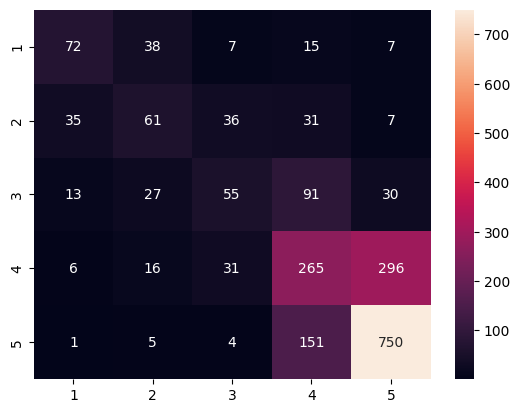

In [76]:
plot_confusion_matrix(y_test, y_pred)

In [77]:
# investigating the perfomence on the train set
y_train_pred = svc_simplest_input.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7572799739710427

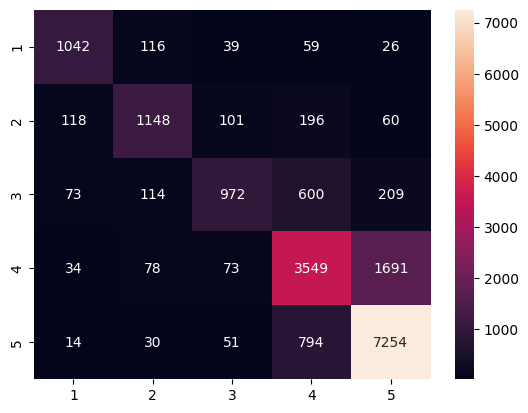

In [78]:
plot_confusion_matrix(y_train, y_train_pred)

### Classification with other parameters

#### Preparing train and test set

In [198]:
# to delete
# reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)

C:\Users\jjasi\AppData\Local\Temp\ipykernel_21704\2440993339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)


In [79]:
# creating a list of concatenated vectors
X = []

for _, row in reviews_for_classification.iterrows():
    x = row.doc2vec.copy()
    x.extend([row.words_number, row.commas, row.average_length])
    X.append(x)

# print to delete
len(X[0])

35

In [80]:
# scaling the values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [82]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [100]:
# increasing C to weaken the L2 regularization
# at first the classifier was predicting only rating 5
svc_metadata = SVC(C=2)
svc_metadata.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [101]:
y_pred = svc_metadata.predict(X_test)
accuracy_score(y_test, y_pred)

0.588780487804878

In [102]:
y_train_pred = svc_metadata.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7948050539558592

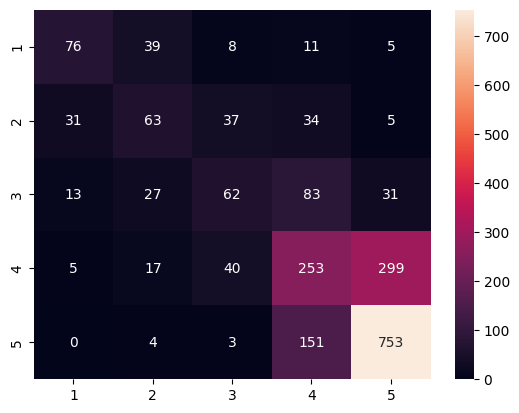

In [103]:
plot_confusion_matrix(y_test, y_pred)

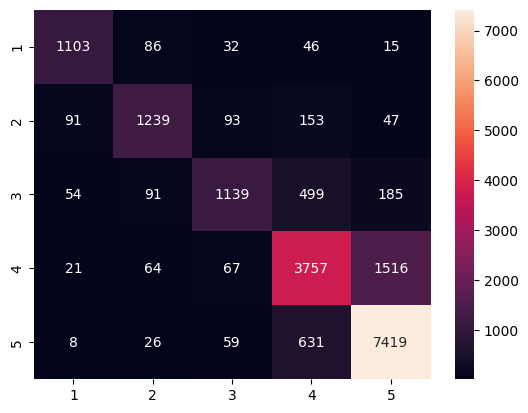

In [104]:
plot_confusion_matrix(y_train, y_train_pred)

The model with the extra inputs works slightly better so from now it will be just this one used.

## KNeighbors

In [105]:
# since it is a very fast non-parametrical algorytm
# looking for best performing n_neighbours value
accuracies = []

for n_neighbours in range(1, 50):
    KNC = KNeighborsClassifier(n_neighbors=n_neighbours)
    KNC.fit(X_train, y_train)
    y_pred = KNC.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

In [106]:
best_n_neighbours = np.argmax(accuracies) + 1

In [107]:
KNC = KNeighborsClassifier(n_neighbors=best_n_neighbours)
KNC.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [108]:
y_pred = KNC.predict(X_test)
accuracy_score(y_test, y_pred)

0.5521951219512196

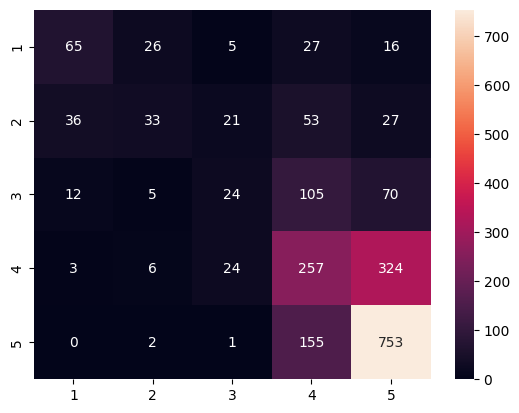

In [109]:
plot_confusion_matrix(y_test, y_pred)

In [110]:
y_train_pred = KNC.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.5981237460007591

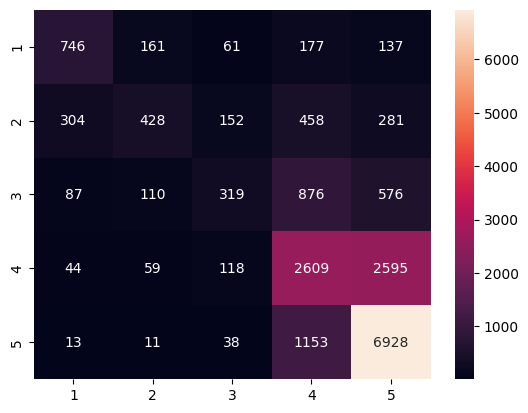

In [111]:
plot_confusion_matrix(y_train, y_train_pred)

## Random Forest

In [112]:
RFC = RandomForestClassifier(max_depth=14, random_state=42)

In [113]:
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, random_state=42)

In [114]:
y_pred = RFC.predict(X_test)
accuracy_score(y_test, y_pred)

0.5487804878048781

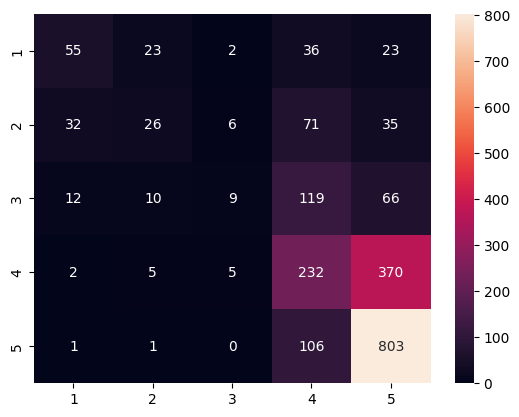

In [115]:
plot_confusion_matrix(y_test, y_pred)

In [116]:
y_train_pred = RFC.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9669757605335936

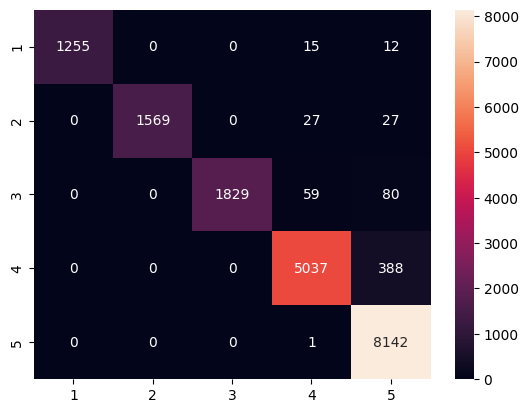

In [117]:
plot_confusion_matrix(y_train, y_train_pred)

## Linear SGD

In [118]:
SGD = SGDClassifier(loss='log_loss', alpha=1e-6, average=10)

In [119]:
SGD.fit(X_train, y_train)

SGDClassifier(alpha=1e-06, average=10, loss='log_loss')

In [120]:
y_pred = SGD.predict(X_test)
accuracy_score(y_test, y_pred)

0.584390243902439

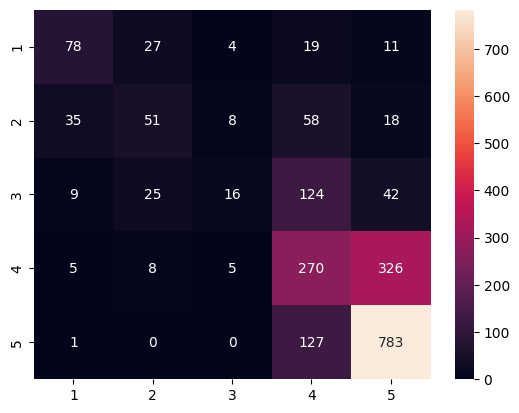

In [121]:
plot_confusion_matrix(y_test, y_pred)

In [122]:
y_train_pred = SGD.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.5844585434629358

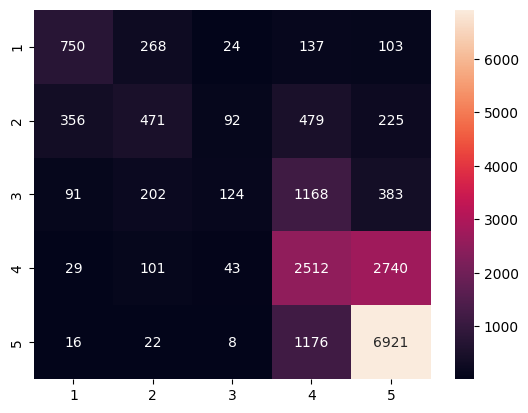

In [123]:
plot_confusion_matrix(y_train, y_train_pred)